In [102]:
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import numpy as np,sys,time
import matplotlib
import os
import numpy as np,sys
import matplotlib.gridspec as gridspec
from keras.utils import np_utils
from keras.models import Sequential
from keras import models, layers
import keras

%matplotlib notebook

np.random.seed(0)

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], 784)


def relu(x, derivation=False):
    if(derivation == False):
        return ((x > 0) * 1.0) * x
    else:
        return (x > 0) * 1.0 

def arctan(x, derivation=False):
    if(derivation == False):
        return np.arctan(x)
    else:
        return 1 / (1 + x ** 2)

def tanh(x, derivation=False):
    if(derivation == False):
        return np.tanh(x)
    else:
        return 1 - np.tanh(x) ** 2

def log(x, derivation=False):
    if(derivation == False):
        return 1 / (1 + np.exp(-1*x))
    else:
        return log(x) * (1 - log(x))    

In [103]:
class layer:
    def __init__(self, size, activation="relu"):
        self.bias = np.zeros(size[1])
        self.weigth = np.random.normal(size=size,scale=(1. / np.sqrt(size[0] / 2.))) *0.005
        self.size = size
        
        if(activation == "relu"):
            self.activation = relu
        elif(activation == "arctan"):
            self.activation = arctan
        elif(activation == "tanh"):
            self.activation = tanh
        elif(activation == "log"):
            self.activation = log
        else:
            raise Exception("unkown activation function")
        self.activation_name = activation
        
        self.next_layer = None
        self.back_layer = None

        # adam
        self.m_weigth = 0
        self.v_weigth = 0
        
        self.m_bias = 0
        self.v_bias = 0
                
class custom_layer:
    def __init__(self, x):
        self.name = "input"
        self.layer_activation = x
        
class model:
    def __init__(self):
        self.root = None
        self.linked = None
        self.last_visit = None
        
        self.count = 0
        self.layers_ref = {
            
        }
        
    def add(self, layer):
        if(self.root == None):
            self.root = layer
            self.linked = layer
            
            self.count += 1
        else:
            layer.name = self.count
            self.linked.next_layer = layer
            old = self.linked
            
            self.count += 1
            
            self.linked = self.linked.next_layer
            self.linked.back_layer = old

        layer.name = self.count - 1
        
        self.layers_ref[str(self.count)] = self.linked
            
    def feed_forward(self, data):
        current_layer = self.root
        feed_forward = data
        
        last_point = None
        
        self.root.back_layer = custom_layer(data)
        
        while current_layer != None:
            current_layer.plain = feed_forward.dot(current_layer.weigth) + current_layer.bias
            current_layer.layer_activation = current_layer.activation(current_layer.plain)
            
            self.last_visit = current_layer
            
            last_point = current_layer.layer_activation
            
            feed_forward = current_layer.layer_activation
            current_layer = current_layer.next_layer
        
        return last_point
    
    def backpropagation(self, type_id):
        current_layer = self.last_visit
        while current_layer != None and not current_layer.name == "input":
            if(current_layer.activation_name == "log"):
                if(type_id == "fake"):
                    current_layer.error = 1/(1.0 - current_layer.layer_activation)
                else:
                    current_layer.error = - 1/current_layer.layer_activation             
                    
            elif(current_layer.activation_name == "relu"):
                forward_layer = current_layer.next_layer
                current_layer.error = (forward_layer.error).dot(forward_layer.weigth.T)
                
            else:
                raise Exception("bug in backward")
            
            current_layer.delta =  current_layer.error * current_layer.activation(current_layer.plain, derivation=True)
            current_layer.last_activation = current_layer.back_layer.layer_activation
            
            current_layer.pending_weigth =  current_layer.last_activation.T.dot(current_layer.delta) 
            current_layer.pending_bias =  current_layer.delta
            
            current_layer = current_layer.back_layer

In [104]:
def update_generator(model, hint):
    index = 0
    current_layer = model.last_visit
    while layer != None  and not current_layer.name == "input":
        if(index == 0):
            start = (-1/hint.last_visit.layer_activation)
         
            current_activation = current_layer
            current_hint = hint.last_visit
            
            while current_hint.name != "input":
                start = ((start) * current_activation.activation(current_hint.plain, derivation=True)).dot(current_hint.weigth.T)
                current_hint = current_hint.back_layer
                current_activation = current_activation.back_layer

            current_layer.error = start
        else:
            forward_layer = current_layer.next_layer
            current_layer.error = (forward_layer.error).dot(forward_layer.weigth.T)
            
        current_layer.delta = current_layer.error * current_layer.activation(current_layer.plain, derivation=True)
        current_layer.last_activation = current_layer.back_layer.layer_activation

        current_layer.new_weigth = current_layer.last_activation.T.dot(current_layer.delta) 
        current_layer.new_bias = current_layer.delta

        index += 1 
        current_layer = current_layer.back_layer

In [105]:
def adam(layer,beta_1=0.9, beta_2=0.999, eps=0.00000001) :
    layer.m_weigth = beta_1 * layer.m_weigth + (1 - beta_1) * layer.new_weigth
    layer.v_weigth = beta_2 * layer.v_weigth + (1 - beta_2) * layer.new_weigth ** 2

    layer.m_bias = beta_1 * layer.m_bias + (1 - beta_1) * layer.new_bias
    layer.v_bias = beta_2 * layer.v_bias + (1 - beta_2) * layer.new_bias ** 2

    layer.weigth = layer.weigth - (learing_rate / (np.sqrt(layer.v_weigth/(1-beta_2) ) + eps)) * (layer.m_weigth/(1-beta_1))
    layer.bias = layer.bias - (learing_rate / (np.sqrt(layer.v_bias /(1-beta_2) ) + eps)) * (layer.m_bias/(1-beta_1)) 

In [106]:
def update_weigths(model, gen=""):
    current_layer = model.root

    while current_layer != None:
        old = deepcopy(current_layer.weigth)
        adam(current_layer)
      #  assert not np.all(old == current_layer.weigth)
        current_layer = current_layer.next_layer

In [107]:
def combine_models(orginal, fake, real):
    layer_orginal = orginal.root
    layer_fake = fake.root
    layer_real = real.root

    while layer_orginal != None:
        layer_orginal.new_weigth = layer_fake.pending_weigth + layer_real.pending_weigth
        layer_orginal.new_bias = layer_fake.pending_bias + layer_real.pending_bias

        layer_orginal = layer_orginal.next_layer
        layer_fake = layer_fake.next_layer
        layer_real = layer_real.next_layer

<IPython.core.display.Javascript object>


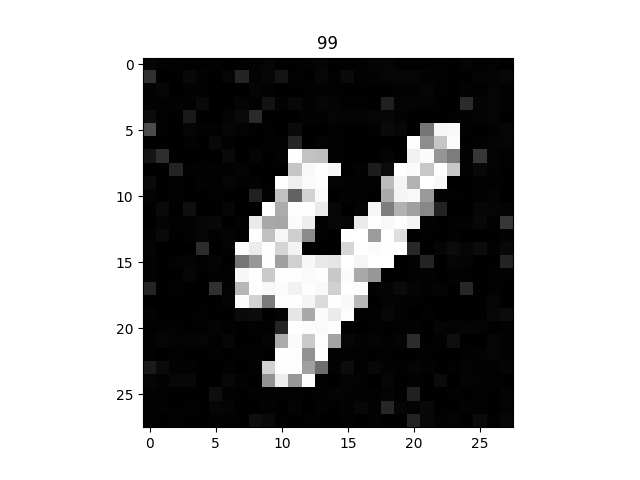

In [111]:
discriminator = model()
discriminator.add(layer((784, 128), activation='relu'))
discriminator.add(layer((128, 1), activation='log'))

generator = model()

generator.add(layer((100, 164), activation="arctan"))
generator.add(layer((164, 228), activation="relu"))
generator.add(layer((228, 356), activation="arctan"))
generator.add(layer((356, 480), activation="relu"))
generator.add(layer((480, 550), activation="tanh"))
generator.add(layer((550, 690), activation="relu"))
generator.add(layer((690, 784), activation="log"))

%matplotlib notebook

learing_rate = 0.0001

figure, axes = plt.subplots(1)
plt.ion()
figure.show()
figure.canvas.draw()


generator_input_size = 100

random_number = np.random.randint(len(x_train) - 1)
current_image = np.expand_dims(x_train[random_number],axis=0)

for i in range(100):
    generator_input = np.random.uniform(-1., 1., size=[1, generator_input_size])

    fake = generator.feed_forward(generator_input)

    real_discriminator = deepcopy(discriminator)
    fake_discriminator = deepcopy(discriminator)

    real_feed_forward = real_discriminator.feed_forward(current_image)
    fake_feed_forward = fake_discriminator.feed_forward(fake)
 
    real_discriminator.backpropagation("real")
    fake_discriminator.backpropagation("fake")

    combine_models(discriminator, fake_discriminator, real_discriminator)
    update_weigths(discriminator)

    axes.set_title(i)
    axes.imshow(fake[0].reshape(28, 28), cmap='gray')
    figure.canvas.draw()

    what_does_the_discrimantor_think = discriminator.feed_forward(fake)
    update_generator(generator, discriminator)
    update_weigths(generator, "generator")

    if i < 20:
        learing_rate *= 0.8